In [1]:
from pandas_datareader import data as datareader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import math
import random
from itertools import combinations
import scipy.stats as ss

/usr/local/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import r2_score, matthews_corrcoef, f1_score, mean_absolute_error
from sklearn.model_selection import BaseCrossValidator

In [3]:
import shap

In [4]:
from mlfinlab.microstructural_features import get_roll_measure, get_roll_impact
from mlfinlab.microstructural_features import get_corwin_schultz_estimator, get_bekker_parkinson_vol
from mlfinlab.microstructural_features import get_bar_based_kyle_lambda, get_bar_based_amihud_lambda, get_bar_based_hasbrouck_lambda
from ta import add_all_ta_features
from ta.utils import dropna
from mlfinlab.features.fracdiff import frac_diff_ffd
from utils import get_meta_barier, getDailyVol

In [5]:
from mlfinlab.backtest_statistics import sharpe_ratio
from mlfinlab.backtest_statistics import probabilistic_sharpe_ratio
from mlfinlab.backtest_statistics import deflated_sharpe_ratio
from mlfinlab.backtest_statistics import information_ratio
from mlfinlab.backtest_statistics import minimum_track_record_length
from mlfinlab.backtest_statistics import drawdown_and_time_under_water

In [6]:
from yahoofinancials import YahooFinancials

In [7]:
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

# Modeling and Training Routines

In [8]:
def create_model():
    clf=RandomForestClassifier(n_estimators=1,
                               criterion='entropy',
                               bootstrap=False,
                               class_weight='balanced_subsample')
    clf=BaggingClassifier(base_estimator=clf,
                         n_estimators=100,
                         max_features=1.)
    return clf

In [9]:
def train_and_evaluate_n_times(X_train, Y_train, X_test, Y_test):
    mmcs, pred_prs = [], []
    for n in range(N_SAMPLES):

        clf = create_model()

        clf.fit(X_train, Y_train)
        pred = clf.predict(X_test)
        pred_pr = clf.predict_proba(X_test)[:, 1]

        mmcs.append(matthews_corrcoef(Y_test, pred))
        pred_prs.append(pred_pr)
    return mmcs, pred_prs

def visualize_mmcs(mmcs):
    plt.figure()
    plt.title(str(np.mean(mmcs)))
    plt.hist(mmcs)
    plt.axvline(np.mean(mmcs), color = 'red')
    plt.show()
    
def backtest_predictions(pred_prs, P_test):
    bagging_strategies, bagging_returns = [], []
    for pred_pr in pred_prs:
        signal = [-(1-p) if p <= 0.5 else p for p in pred_pr]
        bagging_strategies.append((signal * P_test).cumsum())
        bagging_returns.append(signal * P_test)
    return bagging_strategies, bagging_returns

def visualize_backtests(bagging_strategies, P_test):
    plt.figure(figsize = (15, 5))
    for strategy in bagging_strategies:
        plt.plot(strategy, color = 'grey', ls = '--', lw=0.5)
    plt.plot(P_test.cumsum(), lw = 3, label = 'Benchmark')
    plt.plot(np.array(bagging_strategies).mean(axis=0), lw = 3, label = 'Strategy')
    plt.legend()
    plt.show()

# Dataset Routines

In [10]:
def ohclv_to_features(data):
    
    try:
        frac_diff_series = frac_diff_ffd(pd.DataFrame(np.log(data['close'])), 0.7, thresh=1e-4)
    except:
        print('Not calculated')
        frac_diff_series = pd.DataFrame(np.log(data['close'])).pct_change()
        
    # Add all ta features
    technical_features = add_all_ta_features(
        data, open="open", high="high", low="low", close="close", volume="volume")
    
    data['feat_tech_volume_cmf'] = technical_features['volume_cmf']
    data['feat_tech_volatility_dcl'] = technical_features['volatility_dcl']
    data['feat_tech_trend_macd_diff'] = technical_features['trend_macd_diff']
    data['feat_tech_trend_vortex_ind_diff'] = technical_features['trend_vortex_ind_diff']
    data['feat_tech_momentum_stoch_signal'] = technical_features['momentum_stoch_signal']
    data['feat_tech_momentum_tsi'] = technical_features['momentum_tsi']
    
    data['feat_afml_roll_measure'] = get_roll_measure(data['close'], WINDOW)
    data['feat_afml_roll_impact'] = get_roll_impact(data['close'], data['volume'], WINDOW)
    data['feat_afml_corwin_schultz'] = get_corwin_schultz_estimator(data['high'], data['low'], WINDOW)
    data['feat_afml_bekker_parkinson_vol'] = get_bekker_parkinson_vol(data['high'], data['low'], WINDOW)
    data['feat_afml_kyle_lambda'] = get_bar_based_kyle_lambda(data['close'], data['volume'], WINDOW)
    data['feat_afml_amihud_lambda'] = get_bar_based_amihud_lambda(data['close'], data['volume'], WINDOW)
    data['feat_afml_hasbrouck_lambda'] = get_bar_based_hasbrouck_lambda(data['close'], data['volume'], WINDOW)
    
    data['feat_stat_min_frac_close'] = frac_diff_series.rolling(WINDOW).min()
    data['feat_stat_max_frac_close'] = frac_diff_series.rolling(WINDOW).max()
    data['feat_stat_mean_frac_close'] = frac_diff_series.rolling(WINDOW).mean()
    data['feat_stat_std_frac_close'] = frac_diff_series.rolling(WINDOW).std()
    data['feat_stat_skew_frac_close'] = frac_diff_series.rolling(WINDOW).skew()
    data['feat_stat_kurt_frac_close'] = frac_diff_series.rolling(WINDOW).kurt()
    data['feat_stat_autocorr_frac_close'] = frac_diff_series.rolling(WINDOW).apply(lambda x: x.autocorr(), raw=False)
    
    FEATURE_COLUMNS = [d for d in data.columns if 'feat_' in d]
    dataset = data[FEATURE_COLUMNS]
    
    dataset_normalized = {}
    for feature_column in dataset.columns:
        feature_i = dataset[feature_column]
        feature_i_norm = (feature_i - feature_i.rolling(WINDOW).mean()) / feature_i.rolling(WINDOW).std()
        dataset_normalized[feature_column] = feature_i_norm
    dataset_normalized = pd.DataFrame(
           dataset_normalized, index = dataset.index
    )
    
    dataset = dataset_normalized
    dataset['close'] = data['close']
    dataset = dataset.replace([np.inf, -np.inf], np.nan)
    dataset = dataset.dropna()
    
    return dataset

In [11]:
def createXY(inputs, outputs, training=False): 
    
    def flatten_features_window(x):
        mean = x.mean(axis=1)
        std = x.std(axis=1)
        low = x.min(axis=1)
        high = x.max(axis=1)
        open_f = x[:, 0]
        close_f = x[:, -1]
        return close_f
    
    X, Y, P, T = [], [], [], []
    
    # FIXED IID ASSUMPTION (up to some point)
    if training:
        SKIP = WINDOW + HORIZON
    else:
        SKIP = 1
    
    for i in range(INPUT_WINDOW, len(inputs)-HORIZON, SKIP):

        if INPUT_WINDOW > 1:
            window = inputs[i-INPUT_WINDOW:i].values
        else:
            window = inputs.iloc[i].values
        future = (outputs[i+HORIZON] - outputs[i]) / outputs[i]
        future_binary = 1.0 if future > 0 else 0.0

        X.append(window)
        Y.append(future_binary)
        P.append(future)
        T.append(outputs.index[i+HORIZON])

    X, Y, P = np.array(X), np.array(Y), np.array(P)
    
    if INPUT_WINDOW > 1:
        X = flatten_features_window(X)
    return X, Y, P, T

# Metrics Routines

In [12]:
def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = np.abs(ar1(x))
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def smart_sharpe(x):
    return (np.mean(x)/(np.std(x, ddof=1) * autocorr_penalty(x)) * np.sqrt(252))

def calculate_all_metrics(benchmark_returns, strategy_returns, dates_array):
    
    res = {}
    
    benchmark_sharpe = sharpe_ratio(benchmark_returns, entries_per_year=252)
    benchmark_sharpe_smart = smart_sharpe(benchmark_returns)
    strategy_sharpe = sharpe_ratio(strategy_returns, entries_per_year=252)
    strategy_sharpe_smart = smart_sharpe(strategy_returns)
    psr = probabilistic_sharpe_ratio(strategy_sharpe, benchmark_sharpe, len(benchmark_returns))
    all_strategy_sharpes = []
    for r in bagging_returns:
        sr_i = sharpe_ratio(r, entries_per_year=252)
        all_strategy_sharpes.append(sr_i)
    dsr = deflated_sharpe_ratio(strategy_sharpe, all_strategy_sharpes, len(benchmark_returns))
    ir = information_ratio(strategy_returns, benchmark=np.mean(benchmark_returns), entries_per_year=252)
    mtrl = minimum_track_record_length(strategy_sharpe, benchmark_sharpe)

    res['benchmark_mean_returns'] = np.mean(benchmark_returns)
    res['strategy_mean_returns'] = np.mean(strategy_returns) 
    res['benchmark_sharpe'] = benchmark_sharpe
    res['benchmark_sharpe_smart'] = benchmark_sharpe_smart
    res['strategy_sharpe'] = strategy_sharpe
    res['strategy_sharpe_smart'] = strategy_sharpe_smart
    res['probabilistic_sharpe_ratio'] = psr
    res['deflated_sharpe_ratio'] = dsr
    res['information_ratio'] = ir
    res['minimum_track_record_length'] = mtrl

    return res

def calculate_important_features(dataset_train, cutoff_up = 0, cutoff_down = 3, visualize = False):

    X_train, Y_train, P_train, T_train = createXY(dataset_train[FEATURE_COLUMNS], dataset_train['close'], training=True)
    X_train_df = pd.DataFrame(X_train, columns = FEATURE_COLUMNS)
    clf = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', criterion='entropy')
    clf.fit(X_train_df, Y_train)
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_train_df)
    fi0 = np.abs(shap_values[0]).mean(axis=0)
    fi1 = np.abs(shap_values[1]).mean(axis=0)
    fi = fi0 + fi1
    imp = pd.DataFrame({
        'feature': X_train_df.columns.tolist(),
        'mean': fi
    })
    imp = imp.set_index('feature')
    
    if visualize:
        imp.sort_values('mean').plot.barh()
        
    return imp, imp.sort_values('mean')[::-1][cutoff_up:-cutoff_down].index.values.tolist()

In [13]:
def calculate_all_metrics(benchmark_returns, strategy_returns, dates_array, mmcs, pred_prs):
    
    res = {}
    strategy_returns_mean = strategy_returns.mean(axis=0)
    
    benchmark_sharpe = sharpe_ratio(benchmark_returns, entries_per_year=252)
    benchmark_sharpe_smart = smart_sharpe(benchmark_returns)
    strategy_sharpe = sharpe_ratio(strategy_returns_mean, entries_per_year=252)
    strategy_sharpe_smart = smart_sharpe(strategy_returns_mean)
    psr = probabilistic_sharpe_ratio(strategy_sharpe, benchmark_sharpe, len(benchmark_returns))
    all_strategy_sharpes = []
    for r in strategy_returns:
        sr_i = sharpe_ratio(r, entries_per_year=252)
        all_strategy_sharpes.append(sr_i)
    dsr = deflated_sharpe_ratio(strategy_sharpe, all_strategy_sharpes, len(benchmark_returns))
    ir = information_ratio(strategy_returns_mean, benchmark=np.mean(benchmark_returns), entries_per_year=252)
    mtrl = minimum_track_record_length(strategy_sharpe, benchmark_sharpe)
    
    df_for_ddn = pd.DataFrame.from_dict({'Date': dates_array, 
                                         'Benchmark': benchmark_returns,
                                         'Strategy': strategy_returns_mean})
    df_for_ddn = df_for_ddn.set_index('Date')
    df_for_ddn['Cumulative_Benchmark'] = df_for_ddn.Benchmark.cumsum().round(2)
    df_for_ddn['Cumulative_Strategy'] = df_for_ddn.Strategy.cumsum().round(2)
    df_for_ddn['HighValue_Benchmark'] = df_for_ddn['Cumulative_Benchmark'].cummax()
    df_for_ddn['HighValue_Strategy'] = df_for_ddn['Cumulative_Strategy'].cummax()
    df_for_ddn['Drawdown_Benchmark'] = df_for_ddn['Cumulative_Benchmark'] - df_for_ddn['HighValue_Benchmark']
    df_for_ddn['Drawdown_Strategy'] = df_for_ddn['Cumulative_Strategy'] - df_for_ddn['HighValue_Strategy']

    res['benchmark_mean_returns'] = np.mean(benchmark_returns)
    res['strategy_mean_returns'] = np.mean(strategy_returns) 
    res['benchmark_sharpe'] = benchmark_sharpe
    res['benchmark_sharpe_smart'] = benchmark_sharpe_smart
    res['strategy_sharpe'] = strategy_sharpe
    res['strategy_sharpe_smart'] = strategy_sharpe_smart
    res['probabilistic_sharpe_ratio'] = psr
    res['deflated_sharpe_ratio'] = dsr
    res['information_ratio'] = ir
    res['minimum_track_record_length'] = mtrl
    res['benchmark_drawdown'] = df_for_ddn['Drawdown_Benchmark'].quantile(.05)
    res['strategy_drawdown'] = df_for_ddn['Drawdown_Strategy'].quantile(.05)
    res['mmc_mean'] = np.mean(mmcs)
    res['mmc_std'] = np.std(mmcs)
    res['mmc_sharpe'] = res['mmc_mean'] / res['mmc_std']
    res['model_certainty'] = abs(np.array(np.mean(pred_prs)) - 0.5) / 0.5

    return res

# Data reading

In [14]:
TICKER = 'DB'

In [15]:
aapl_yf = yahoo_financials_tech = YahooFinancials([TICKER])
data = aapl_yf.get_historical_price_data('2000-01-01', '2020-08-01', 'daily')

In [16]:
data = pd.DataFrame(data[TICKER]['prices'])
data = data.set_index('formatted_date')
data_original = data.dropna()

# Data Preparation

In [17]:
WINDOW = 14
INPUT_WINDOW = 1 # REDUCED THE CONTEXT
HORIZON = 1
N_SAMPLES = 25

In [18]:
dataset = ohclv_to_features(data_original)

In [19]:
FEATURE_COLUMNS = [d for d in dataset.columns if 'feat_' in d]

# CPCV Generation

In [20]:
class CPCV(BaseCrossValidator):
    # TODO: add purge "holes" !!!
    def __init__(self, X, N, k):
        self.X = X
        self.N = N
        self.k = k

    def generate_eras(self):
        # assuming exact division, we will cut-off small piece of time series
        # in the very beginning
        return np.array(sum([
                    [i] * (len(self.X) // self.N) for i in range(self.N)
                    ], []
                   )
        )
        
    def split(self, X=None, y=None, groups=None):
        # removing first m items from time series
        eras = self.generate_eras()
        len_diff = abs(len(self.X) - len(eras))
        comb = list(combinations(range(self.N), self.N-self.k))
        all_splits = range(self.N)

        for combination in comb:
            train_indices, test_indices = [], []
            for c in combination:
                indices_train = list(np.where(eras == c)[0])
                train_indices.extend(indices_train)
            for t in list(set(all_splits) - set(combination)):
                indices_test = list(np.where(eras == t)[0])
                test_indices.extend(indices_test)
            yield(train_indices, test_indices)  
              
    def get_n_splits(self):
        comb = combinations(range(self.N), self.N-self.k)
        return len(list(comb))

# Probability of strategy overfit

In [66]:
%%time

N = 7
k = 3

cpcv = CPCV(dataset, N, k)

ALL_P_TESTS_OOS = []
ALL_RETURNS_OOS = []
ALL_DATES_OOS = []
ALL_MMCS_OOS, ALL_PREDS_OOS = [], []
FEATURE_IMPORTANCES_OOS = []

ALL_P_TESTS_IS = []
ALL_RETURNS_IS = []
ALL_DATES_IS = []
ALL_MMCS_IS, ALL_PREDS_IS = [], []
FEATURE_IMPORTANCES_IS = []

for e, (train_ids, test_ids) in enumerate(cpcv.split()):
    print('processing split', e+1, '/', cpcv.get_n_splits())
    
    dataset_train, dataset_test = dataset.iloc[train_ids], dataset.iloc[test_ids]
    imp, IMPORTANT_FEATURES = calculate_important_features(dataset_train)
    
    X_train, Y_train, P_train, T_train = createXY(dataset_train[FEATURE_COLUMNS], dataset_train['close'], training=True)
    X_test, Y_test, P_test, T_test = createXY(dataset_test[FEATURE_COLUMNS], dataset_test['close'])
    
    mmcs, pred_prs = train_and_evaluate_n_times(X_train, Y_train, X_test, Y_test)
    bagging_strategies, bagging_returns = backtest_predictions(pred_prs, P_test)
    
    ALL_RETURNS_OOS.append(np.array(bagging_returns))
    ALL_P_TESTS_OOS.append(P_test)
    ALL_DATES_OOS.append(T_test)
    ALL_MMCS_OOS.append(mmcs)
    ALL_PREDS_OOS.append(pred_prs)
    FEATURE_IMPORTANCES_OOS.append(imp)
    
    mmcs_is, pred_prs_is = train_and_evaluate_n_times(X_train, Y_train, X_train, Y_train)
    bagging_strategies_is, bagging_returns_is = backtest_predictions(pred_prs_is, P_train) 
    
    ALL_RETURNS_IS.append(np.array(bagging_returns_is))
    ALL_P_TESTS_IS.append(P_train)
    ALL_DATES_IS.append(T_train)
    ALL_MMCS_IS.append(mmcs_is)
    ALL_PREDS_IS.append(pred_prs_is)
    FEATURE_IMPORTANCES_IS.append(imp)

processing split 1 / 35
processing split 2 / 35
processing split 3 / 35
processing split 4 / 35
processing split 5 / 35
processing split 6 / 35
processing split 7 / 35
processing split 8 / 35
processing split 9 / 35
processing split 10 / 35
processing split 11 / 35
processing split 12 / 35
processing split 13 / 35
processing split 14 / 35
processing split 15 / 35
processing split 16 / 35
processing split 17 / 35
processing split 18 / 35
processing split 19 / 35
processing split 20 / 35
processing split 21 / 35
processing split 22 / 35
processing split 23 / 35
processing split 24 / 35
processing split 25 / 35
processing split 26 / 35
processing split 27 / 35
processing split 28 / 35
processing split 29 / 35
processing split 30 / 35
processing split 31 / 35
processing split 32 / 35
processing split 33 / 35
processing split 34 / 35
processing split 35 / 35
CPU times: user 18min 52s, sys: 12.5 s, total: 19min 5s
Wall time: 21min 53s


In [67]:
df_results_is = []
for b_ret, s_ret, dates, mmcs, preds, fis in zip(ALL_P_TESTS_IS, 
                                                 ALL_RETURNS_IS, 
                                                 ALL_DATES_IS, 
                                                 ALL_MMCS_IS,
                                                 ALL_PREDS_IS,
                                                 FEATURE_IMPORTANCES_IS):
    res = calculate_all_metrics(
            np.array(b_ret), 
            np.array(s_ret), 
            [datetime.strptime(date, "%Y-%m-%d").date() for date in dates],
            mmcs, 
            fis
    )
    df_results_is.append(res)
df_results_is = pd.DataFrame(df_results_is)

In [68]:
df_results_oos = []
for b_ret, s_ret, dates, mmcs, preds, fis in zip(ALL_P_TESTS_OOS, 
                                                 ALL_RETURNS_OOS, 
                                                 ALL_DATES_OOS, 
                                                 ALL_MMCS_OOS, 
                                                 ALL_PREDS_OOS, 
                                                 FEATURE_IMPORTANCES_OOS):
    res = calculate_all_metrics(
            np.array(b_ret), 
            np.array(s_ret), 
            [datetime.strptime(date, "%Y-%m-%d").date() for date in dates],
            mmcs, 
            fis
    )
    df_results_oos.append(res)
df_results_oos = pd.DataFrame(df_results_oos)

In [69]:
w_c_is = df_results_is['strategy_sharpe']
w_c_oos = df_results_oos['strategy_sharpe']

# Regression

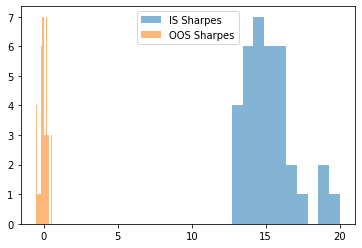

In [80]:
plt.figure()
plt.hist(w_c_is.values, label = 'IS Sharpes', alpha = 0.55)
plt.hist(w_c_oos.values, label = 'OOS Sharpes', alpha = 0.55)
plt.legend()
plt.show()

In [70]:
import statsmodels.api as sm

In [71]:
Y = w_c_oos
X = w_c_is
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

In [72]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        strategy_sharpe   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.7108
Date:                Sun, 29 Nov 2020   Prob (F-statistic):              0.405
Time:                        20:19:20   Log-Likelihood:                -4.2922
No. Observations:                  35   AIC:                             12.58
Df Residuals:                      33   BIC:                             15.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3459      0.428      0.809      0.424      -0.524       1.216
strategy_sharpe    -0.0236      0.028     -0.843      0.405      -0.080       0.033
==============================================================================
Omnibus:                        0.349   Durbin-Watson:                   1.318
Prob(Omnibus):                  0.840   Jarque-Bera (JB):                0.496
Skew:                           0.191   Prob(JB):                        0.780
Kurtosis:                       2.560   Cond. No.                         138.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
x = np.arange(np.min(w_c_is), np.max(w_c_is), 0.5)
y = 0.3459 + -0.0236 * x

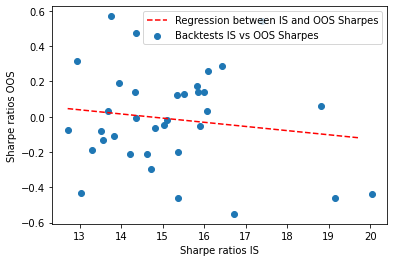

In [90]:
plt.figure()
plt.scatter(w_c_is, w_c_oos, label = 'Backtests IS vs OOS Sharpes')
plt.plot(x, y, color = 'red', ls = '--', label = 'Regression between IS and OOS Sharpes')
plt.xlabel('Sharpe ratios IS')
plt.ylabel('Sharpe ratios OOS')
plt.legend()
plt.show()

# Logits

In [81]:
n_star = np.argmax(w_c_is)
w_c = (ss.rankdata(w_c_oos) - n_star) / len(w_c_oos)
w_c = w_c + np.abs(np.min(w_c))

In [82]:
y_c = np.log(w_c / (1 - w_c))
y_c[y_c==-np.inf] = 0

In [84]:
y_c_neg = y_c[y_c < 0]
y_c_neg = (y_c_neg - y_c_neg.min()) / (y_c_neg.max() - y_c_neg.min())
pbo = np.mean(y_c_neg)
pbo

0.6507251193096577

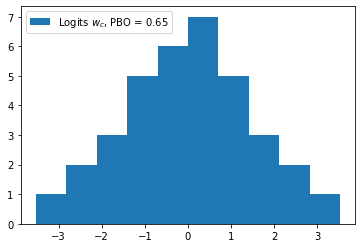

In [88]:
plt.figure()
plt.hist(y_c, label = 'Logits $w_c$, PBO = ' + str(np.round(pbo, 2)))
plt.legend()
plt.show()

# Strategy risk

In [106]:
def binHR(sl, pt, n, tSR):
    a = (n + tSR**2) * (pt - sl)**2
    b = (2*n*sl - tSR**2*(pt-sl))*(pt-sl)
    c = n*sl**2
    p = (-b + (b**2 - 4*a*c)**0.5) / (2.*a)
    return p

In [107]:
def probFailure(ret, freq, tSR):
    # Derive probability that strategy may fail
    rPos, rNeg = ret[ret>0].mean(), ret[ret<=0].mean()
    p = ret[ret>0].shape[0] / float(ret.shape[0])
    thresP = binHR(rNeg, rPos, freq, tSR)
    risk = ss.norm.cdf(thresP, p, p*(1-p)) # approximation to bootstrap
    return risk

In [136]:
failure_probs = []
for returns in ALL_RETURNS_OOS:
    some_returns = returns.mean(axis=0)
    pf = probFailure(some_returns, 260, 0.0)
    failure_probs.append(pf)

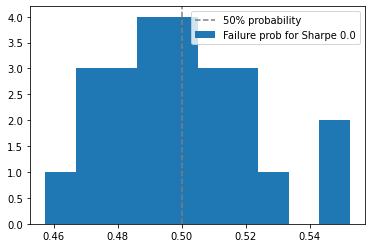

In [137]:
plt.figure()
plt.hist(failure_probs, label = 'Failure prob for Sharpe 0.0')
plt.axvline(0.5, ls = '--', color = 'grey', label = '50% probability')
plt.legend()
plt.show()

In [120]:
len(ALL_RETURNS_OOS)

35